In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset_org import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers_old import training

# Camera / Dataset

In [2]:
import torch
from torch.utils.data import DataLoader

# Batch size
batch_size = 1024

# Fetch rays (might be [N,H,W,3], [H,W,3], or already flattened [M,3])
o, d, target_px_values = get_rays(datapath='pollen_100', mode='train')

print(f"Fetched o.shape={o.shape}, dims={o.ndim}")

# Dynamically flatten for training
o_flat, d_flat, t_flat = None, None, None
if o.ndim == 4:
    N, H, W, C = o.shape
    o_flat = torch.from_numpy(o).reshape(-1, C).float()
    d_flat = torch.from_numpy(d).reshape(-1, C).float()
    t_flat = torch.from_numpy(target_px_values).reshape(-1, C).float()
elif o.ndim == 3:
    H, W, C = o.shape
    o_flat = torch.from_numpy(o).reshape(-1, C).float()
    d_flat = torch.from_numpy(d).reshape(-1, C).float()
    t_flat = torch.from_numpy(target_px_values).reshape(-1, C).float()
elif o.ndim == 2:
    o_flat = torch.from_numpy(o).float()
    d_flat = torch.from_numpy(d).float()
    t_flat = torch.from_numpy(target_px_values).float()
else:
    raise ValueError(f"Unsupported o.ndim={o.ndim}")

# Training DataLoader
dataset = torch.cat((o_flat, d_flat, t_flat), dim=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Warm-up loader: center-crop half the spatial dims if available
if o.ndim >= 3:
    crop_frac = 0.5
    crop_h = int((H if o.ndim==4 else H) * crop_frac)
    crop_w = int((W if o.ndim==4 else W) * crop_frac)
    start_h = ((H if o.ndim==4 else H) - crop_h) // 2
    start_w = ((W if o.ndim==4 else W) - crop_w) // 2

    if o.ndim == 4:
        o_crop = o[:, start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        d_crop = d[:, start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        t_crop = target_px_values[:, start_h:start_h+crop_h, start_w:start_w+crop_w, :]
    else:
        o_crop = o[start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        d_crop = d[start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        t_crop = target_px_values[start_h:start_h+crop_h, start_w:start_w+crop_w, :]

    C_crop = o_crop.shape[-1]
    o_crop_flat = torch.from_numpy(o_crop).reshape(-1, C_crop).float()
    d_crop_flat = torch.from_numpy(d_crop).reshape(-1, C_crop).float()
    t_crop_flat = torch.from_numpy(t_crop).reshape(-1, C_crop).float()

    warmup_dataset = torch.cat((o_crop_flat, d_crop_flat, t_crop_flat), dim=1)
    dataloader_warmup = DataLoader(warmup_dataset, batch_size=batch_size, shuffle=True)
    print(f"Warm-up crop: {crop_h}×{crop_w}, total rays={len(warmup_dataset)}")
else:
    dataloader_warmup = None
    print("Skipping warm-up loader: spatial dims unknown")

# Test loader
test_o, test_d, test_t = get_rays('pollen_100', mode='test')
print(f"Fetched test_o.shape={test_o.shape}, dims={test_o.ndim}")

# Flatten test similarly
t_flatest, d_flatest, t_flatest = None, None, None
if test_o.ndim >= 3:
    C_test = test_o.shape[-1]
    t_flatest = torch.from_numpy(test_o.reshape(-1, C_test)).float()
    d_flatest = torch.from_numpy(test_d.reshape(-1, C_test)).float()
    t_flatest = torch.from_numpy(test_t.reshape(-1, C_test)).float()
else:
    t_flatest = torch.from_numpy(test_o).float()
    d_flatest = torch.from_numpy(test_d).float()
    t_flatest = torch.from_numpy(test_t).float()

test_dataset = torch.cat((t_flatest, d_flatest, t_flatest), dim=1)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train rays={len(dataset)}, Test rays={len(test_dataset)}")

Fetched o.shape=(90, 160000, 3), dims=3
Warm-up crop: 45×80000, total rays=3600000
Fetched test_o.shape=(10, 160000, 3), dims=3
Train rays=14400000, Test rays=1600000


# Training

100%|██████████| 3516/3516 [01:23<00:00, 42.33it/s]


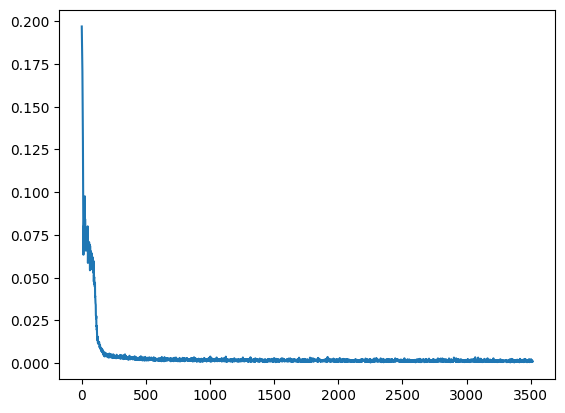

  0%|          | 35/14063 [00:02<13:25, 17.42it/s] 


KeyboardInterrupt: 

In [3]:
device = 'cuda'

tn = 8.
tf = 12.
nb_epochs = 10
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [ ]:
torch.save(model, 'model_nerf_30')